# Dataset prepareation
First the dataset needs to be loaded and modified to only include the labels we want. This is done by merging unchosen labels to their closest related label. Cases where text has multiple labels for one entry are handled by choosing the label which has the lowest representation in the dataset so far.

In [15]:
from data.dataset import EmotionsDataset

train_dataset = EmotionsDataset(split="train")
valid_dataset = EmotionsDataset(split="valid")
test_dataset = EmotionsDataset(split="test")

No config specified, defaulting to: go_emotions/simplified
Found cached dataset go_emotions (C:/Users/ryans/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d)
No config specified, defaulting to: go_emotions/simplified
Found cached dataset go_emotions (C:/Users/ryans/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d)
No config specified, defaulting to: go_emotions/simplified
Found cached dataset go_emotions (C:/Users/ryans/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d)


In [16]:
print(train_dataset[0])
print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

("My favourite food is anything I didn't have to cook myself.", 13)
43410
5426
5427


# Experiment 1: Different SVM kernel types
This experiment looks at the different kernel options used to build a support vector, the kernels covered are: linear, polynomial, radial basis function and sigmoid.
## Vectorisation using TFIDF 
The input text needs to be vectorised before it can be used for training a support vector machine. First stop words and non-alphabetic words are removed before being lemmatised. 

In [17]:
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from nltk import download, pos_tag
download('punkt')
download('wordnet')
download('omw-1.4')
download('averaged_perceptron_tagger')
download('stopwords')

from collections import defaultdict

def lem_text(text):
    text = [word.lower() for word in text]
    text = [word_tokenize(word) for word in text]

    word_tags = defaultdict(lambda: wordnet.NOUN)
    word_tags['J'] = wordnet.ADJ
    word_tags['V'] = wordnet.VERB
    word_tags['R'] = wordnet.ADV

    for i, words in enumerate(text):
        lemmed_text = []
        lemmer = WordNetLemmatizer()

        for word, tag in pos_tag(words):
            if word not in stopwords.words('english') and word.isalpha():
                lem_word = lemmer.lemmatize(word, word_tags[tag[0]])
                lemmed_text.append(lem_word)

        text[i] = str(lemmed_text)

    return text

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ryans\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ryans\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ryans\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ryans\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ryans\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Once the text of all datasets has been lemmatised, the training data is used to extract the most important word tfidf features. These features are used to convert all dataset text entries into vectors.

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

train_dataset.x = lem_text(train_dataset.x)
valid_dataset.x = lem_text(valid_dataset.x)
test_dataset.x = lem_text(test_dataset.x)

tfidf_vectoriser = TfidfVectorizer(max_features=1000)
tfidf_vectoriser.fit(train_dataset.x)

train_dataset.x = tfidf_vectoriser.transform(train_dataset.x)
valid_dataset.x = tfidf_vectoriser.transform(valid_dataset.x)
test_dataset.x = tfidf_vectoriser.transform(test_dataset.x)

## Confusion Matrix
A confusion matrix is used to visualise the performance of the classifier, this helps us see which labels the classifiers are making the most mistakes on.
The dataset is largely saturated by neutral tags, this means a raw confusion matrix turns out dark for all values apart from neural-neutral, to solve this my confusion matrix displays the log values.

In [19]:
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
from data.dataset import label_names, chosen_labels

def get_label_names():
    names = []

    for label in chosen_labels:
        names.append(label_names[label])
    names.append(label_names[27])

    return names

def display_confusion_matrix(preds, y):
    confusion_matrix = np.ones((14,14)).astype(np.int32)

    for pred, label in zip(preds, y):
        confusion_matrix[pred, label] += 1

    confusion_matrix = np.log2(confusion_matrix)
    
    chosen_label_names = get_label_names()
    heatmap_confusion_matrix = pd.DataFrame(confusion_matrix, index=chosen_label_names, columns=chosen_label_names)

    ax = plt.axes()
    sb.heatmap(heatmap_confusion_matrix, annot=True, ax=ax)
    ax.set_title("Log2 Confusion Matrix")


## SVM kernel results
The performance of the SVM is evaluated with accuracy, recall, precision and f1 score

### Linear Kernel

Test Accuracy:  54.30256126773539


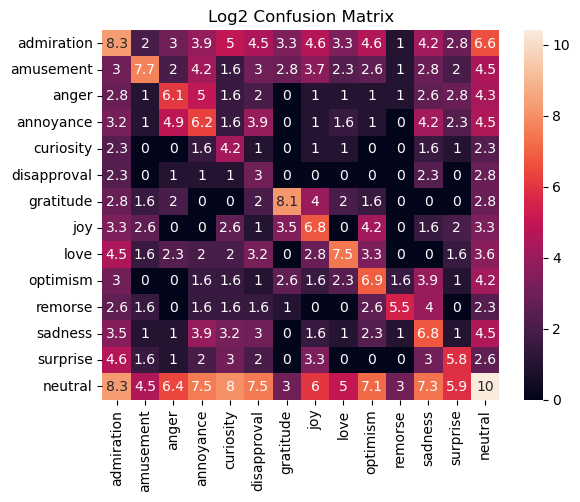

In [24]:
from sklearn import svm
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

svm_linear = svm.SVC(kernel='linear')
svm_linear.fit(train_dataset.x, train_dataset.y)
preds = svm_linear.predict(test_dataset.x)

display_confusion_matrix(preds, test_dataset.y)

acc = accuracy_score(test_dataset.y, preds)
recall = recall_score(test_dataset.y, preds)
prec = precision_score(test_dataset.y, preds)
f1 = f1_score(test_dataset.y, preds)

print("Test Accuracy: ", acc)
print("Test Recall: ", recall)
print("Test Precision: ", prec)
print("Test F1: ", f1)

### Polynomial Kernel

Test Accuracy:  45.5131748664087


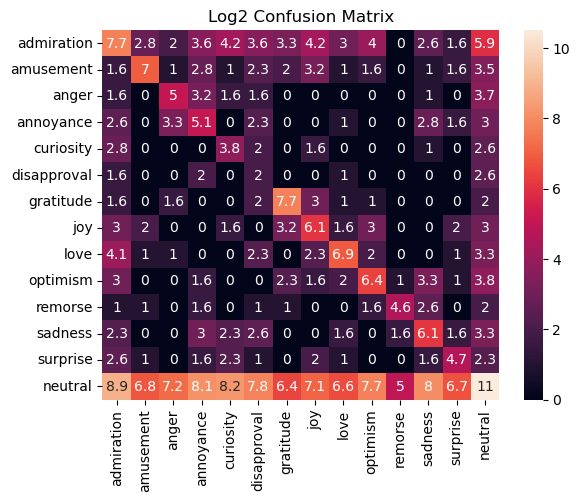

In [21]:
svm_poly = svm.SVC(kernel='poly')
svm_poly.fit(train_dataset.x, train_dataset.y)
preds = svm_poly.predict(test_dataset.x)

display_confusion_matrix(preds, test_dataset.y)

acc = accuracy_score(test_dataset.y, preds)
recall = recall_score(test_dataset.y, preds)
prec = precision_score(test_dataset.y, preds)
f1 = f1_score(test_dataset.y, preds)

print("Test Accuracy: ", acc)
print("Test Recall: ", recall)
print("Test Precision: ", prec)
print("Test F1: ", f1)

### Sigmoid Kernel

Test Accuracy:  52.423069836005155


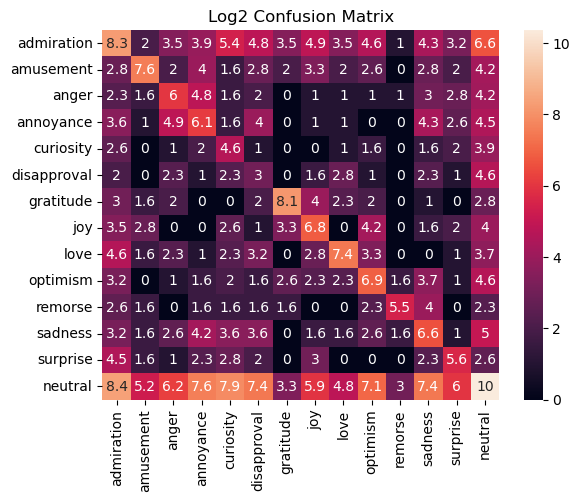

In [22]:
svm_sig = svm.SVC(kernel='sigmoid')
svm_sig.fit(train_dataset.x, train_dataset.y)
preds = svm_sig.predict(test_dataset.x)

display_confusion_matrix(preds, test_dataset.y)

acc = accuracy_score(test_dataset.y, preds)
recall = recall_score(test_dataset.y, preds)
prec = precision_score(test_dataset.y, preds)
f1 = f1_score(test_dataset.y, preds)

print("Test Accuracy: ", acc)
print("Test Recall: ", recall)
print("Test Precision: ", prec)
print("Test F1: ", f1)

### Radial Basis Function Kernel

Test Accuracy:  54.763220932375155


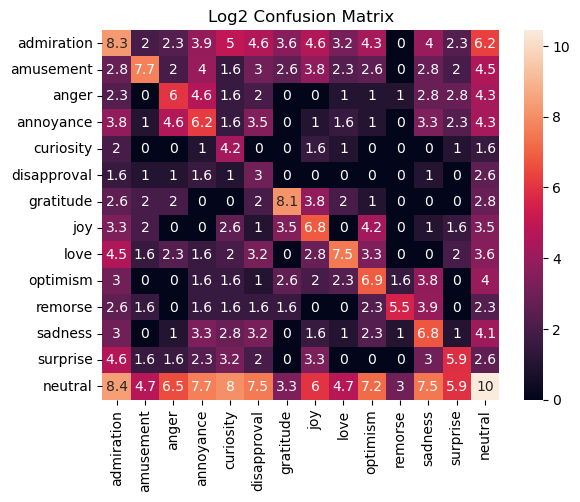

In [23]:
svm_rbf = svm.SVC(kernel='rbf')
svm_rbf.fit(train_dataset.x, train_dataset.y)
preds = svm_rbf.predict(test_dataset.x)

display_confusion_matrix(preds, test_dataset.y)

acc = accuracy_score(test_dataset.y, preds)
recall = recall_score(test_dataset.y, preds)
prec = precision_score(test_dataset.y, preds)
f1 = f1_score(test_dataset.y, preds)

print("Test Accuracy: ", acc)
print("Test Recall: ", recall)
print("Test Precision: ", prec)
print("Test F1: ", f1)

## Conclusion
